In [1]:
# Block 1: Imports and Model Setup
import numpy as np
import torch
from torch import nn, optim
import os
from tqdm.auto import tqdm
import torchaudio
from transformers import HubertForSequenceClassification, Wav2Vec2Processor
from sklearn.metrics import roc_curve
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load pre-trained Hubert model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=2)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertLayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (pro

In [2]:
# Block 2: Helper Functions
def readtxtfile(path):
    with open(path, 'r') as file:
        text = file.read().splitlines()
        return text

def getlabels(path):
    text = readtxtfile(path)
    filename2label = {}
    for item in tqdm(text):
        key = item.split(' ')[1]
        value = item.split(' ')[-1]
        filename2label[key] = value
    return filename2label

In [3]:
# import os

# def count_files_in_directory(directory_path):
#     return sum(1 for f in os.scandir(directory_path) if f.is_file())

# # Example usage
# directory_path = '/kaggle/input/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_dev/flac'
# num_files = count_files_in_directory(directory_path)
# print(f"Number of files in '{directory_path}': {num_files}")

In [4]:
# Block 3: Dataset Class and Collate Function
class ASVSpoof(torch.utils.data.Dataset):
    def __init__(self, audio_files_path, filename2label, processor, start_idx=0, chunk_size=1000):
        self.audio_files_path = audio_files_path
        self.filename2label = filename2label
        self.processor = processor
        self.start_idx = start_idx
        self.chunk_size = chunk_size
        self.audio_files = os.listdir(self.audio_files_path)[start_idx:start_idx+chunk_size]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_name = self.audio_files[idx]
        file_path = os.path.join(self.audio_files_path, file_name)
        try:
            waveform, sample_rate = torchaudio.load(file_path)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            if sample_rate != 16000:
                resampler = torchaudio.transforms.Resample(sample_rate, 16000)
                waveform = resampler(waveform)
            inputs = self.processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.squeeze()
        except Exception as e:
            print(f"Failed to load or process {file_path}: {e}")
            return None, None
        label = self.filename2label.get(file_name.split('.')[0], -1)
        return input_values, int(label == 'spoof')

In [5]:
# Collate function
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if not batch:
        return None, None
    input_values, labels = zip(*batch)
    max_len = max(input_values, key=lambda x: x.shape[0]).shape[0]
    padded_inputs = torch.stack([torch.nn.functional.pad(x, (0, max_len - x.shape[0])) for x in input_values])
    labels = torch.tensor(labels)
    return padded_inputs, labels

In [6]:
# Block 4: Training Utilities
def early_stopping(val_loss, best_val_loss, counter, patience):
    if val_loss < best_val_loss:
        return False, 0  # Reset counter
    else:
        counter += 1
        if counter >= patience:
            return True, counter  # Stop training
        return False, counter

def evaluate_model(val_loader):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            if inputs is None or labels is None:
                continue
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_predictions
    return avg_loss, accuracy

In [7]:
train_audio_files_path_la = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
train_labels_path_la = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'

train_audio_files_path_pa = '/kaggle/input/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_train/flac'
train_labels_path_pa = '/kaggle/input/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.train.trn.txt'

# Adjust paths for LA and PA development sets (dev set for validation)
val_audio_files_path_la = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac'
val_labels_path_la = '/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt'
val_audio_files_path_pa = '/kaggle/input/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_dev/flac'
val_labels_path_pa = '/kaggle/input/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.dev.trl.txt'

# Load validation labels
val_filename2label_la = getlabels(val_labels_path_la)
val_filename2label_pa = getlabels(val_labels_path_pa)


  0%|          | 0/24844 [00:00<?, ?it/s]

  0%|          | 0/29700 [00:00<?, ?it/s]

In [8]:
# Training parameters
num_epochs = 1
chunk_size = 3000  # Load 3000 files at a time
total_files_la = 25000
total_files_pa = 50000
total_val_files = 24000  # Use 25k files from each of LA and PA dev sets for validation
batch_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda')
criterion = nn.CrossEntropyLoss()

# Helper function to clear memory
def clear_memory():
    torch.cuda.empty_cache()

# Validation function
def validate_model():
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_predictions = 0
    
    with torch.no_grad():
        for start_idx in range(0, total_val_files, chunk_size):
            val_dataset_chunk_la = ASVSpoof(val_audio_files_path_la, val_filename2label_la, processor, start_idx, chunk_size // 3)
            val_dataset_chunk_pa = ASVSpoof(val_audio_files_path_pa, val_filename2label_pa, processor, start_idx, chunk_size * 2 // 3)
            val_dataset_chunk = torch.utils.data.ConcatDataset([val_dataset_chunk_la, val_dataset_chunk_pa])
            val_loader = torch.utils.data.DataLoader(val_dataset_chunk, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=True)

            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with torch.amp.autocast('cuda'):
                    outputs = model(inputs).logits
                    loss = criterion(outputs, labels)
                    
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_val_predictions += (predicted == labels).sum().item()
                total_val_predictions += labels.size(0)

    avg_val_loss = total_val_loss / total_val_predictions
    val_accuracy = 100 * correct_val_predictions / total_val_predictions
    return avg_val_loss, val_accuracy

In [9]:
# # Check for available GPUs
# print(f'Available GPUs: {torch.cuda.device_count()}')

# # Load labels for LA and PA training sets
# filename2label_la = getlabels(train_labels_path_la)
# filename2label_pa = getlabels(train_labels_path_pa)

# # Enable DataParallel to use both GPUs
# model = torch.nn.DataParallel(model)
# model = model.to(device)  # Move the model to the available device(s)

# # Training loop
# for epoch in range(num_epochs):
#     print(f'Starting epoch {epoch + 1}/{num_epochs}')

#     for start_idx_la, start_idx_pa in zip(range(0, total_files_la, chunk_size // 3), range(0, total_files_pa, chunk_size * 2 // 3)):
#         print(f'Loading chunk starting at LA: {start_idx_la}, PA: {start_idx_pa}')

#         # Load a chunk of LA and PA data for training
#         train_dataset_chunk_la = ASVSpoof(train_audio_files_path_la, filename2label_la, processor, start_idx_la, chunk_size // 3)
#         train_dataset_chunk_pa = ASVSpoof(train_audio_files_path_pa, filename2label_pa, processor, start_idx_pa, chunk_size * 2 // 3)

#         # Combine LA and PA datasets for training
#         train_dataset_chunk = torch.utils.data.ConcatDataset([train_dataset_chunk_la, train_dataset_chunk_pa])
#         train_loader = torch.utils.data.DataLoader(train_dataset_chunk, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, pin_memory=True)

#         model.train()
#         total_loss = 0
#         correct_predictions = 0
#         total_predictions = 0

#         progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', ncols=100)

#         for inputs, labels in progress_bar:
#             # Ensure inputs and labels are on the same device
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()

#             # Use the device_type argument in autocast
#             with torch.amp.autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
#                 outputs = model(inputs).logits
#                 loss = criterion(outputs, labels)

#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#             total_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             correct_predictions += (predicted == labels).sum().item()
#             total_predictions += labels.size(0)

#             progress_bar.set_postfix({
#                 'loss': f'{loss.item():.4f}',
#                 'acc': f'{100 * correct_predictions / total_predictions:.2f}%'
#             })

#         avg_loss = total_loss / len(train_loader)
#         accuracy = 100 * correct_predictions / total_predictions
#         print(f'Chunk stats: Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

#         # Clear memory after processing each chunk
#         clear_memory()

#     # Validate after each epoch
#     val_loss, val_accuracy = validate_model()
#     print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

In [10]:
# # Save the model
# torch.save(model.state_dict(), 'hubert_model.pt')

In [11]:
import torch
import kagglehub
from transformers import HubertForSequenceClassification

# Load the model's architecture
model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=2)

# Download the fine-tuned model from KaggleHub
model_path = "/kaggle/input/hubert20000/pytorch/default/1/hubert_model (1).pt"

# Load the state_dict of the fine-tuned model
state_dict = torch.load(model_path, map_location=torch.device('cpu'))  # Use 'cpu' if you are loading on CPU

# Load the fine-tuned weights into the model's architecture with strict=False
model.load_state_dict(state_dict, strict=False)

# Move model to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Put model in evaluation mode
model.eval()

print("Model loaded successfully and ready for inference or further training!")

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully and ready for inference or further training!


In [12]:
# Define paths to validation data
val_audio_files_path = '/kaggle/input/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_eval/flac'
val_labels_path = '/kaggle/input/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.eval.trl.txt'

# Load validation labels
val_filename2label = getlabels(val_labels_path)

# Create validation dataset and loader
val_dataset = ASVSpoof(val_audio_files_path, val_filename2label, processor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, pin_memory=True)

  0%|          | 0/134730 [00:00<?, ?it/s]

In [13]:
# for ele in val_filename2label:
#     print(ele)
# val_filename2label['LA_D_1047731']

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_scores = []
    all_predictions = []  # Store predictions for confusion matrix

    # Initialize manual counts for TP, TN, FP, FN
    tp, tn, fp, fn = 0, 0, 0, 0
    total_ones_predicted, total_zeros_predicted = 0, 0  # Track total number of 1s and 0s predicted
    total_ones_actual, total_zeros_actual = 0, 0  # Track actual labels

    with torch.no_grad():
        for inputs, labels in data_loader:
            if inputs is None or labels is None:
                continue  # Skip invalid entries
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predicted class
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            # Store all labels, predictions, and scores for metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_scores.extend(outputs.softmax(dim=1)[:, 1].cpu().numpy())  # Get scores for the positive class

            # Count how many times 1 is predicted vs 0 in the current batch
            num_ones_predicted = (predicted == 1).sum().item()
            num_zeros_predicted = (predicted == 0).sum().item()

            # Count actual number of 1s and 0s in labels
            num_ones_actual = (labels == 1).sum().item()
            num_zeros_actual = (labels == 0).sum().item()

            total_ones_predicted += num_ones_predicted
            total_zeros_predicted += num_zeros_predicted
            total_ones_actual += num_ones_actual
            total_zeros_actual += num_zeros_actual

            # Manually count TP, TN, FP, FN
            for p, l in zip(predicted.cpu().numpy(), labels.cpu().numpy()):
                if p == 1 and l == 1:
                    tp += 1  # True Positive
                elif p == 0 and l == 0:
                    tn += 1  # True Negative
                elif p == 1 and l == 0:
                    fp += 1  # False Positive
                elif p == 0 and l == 1:
                    fn += 1  # False Negative

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct_predictions / total_predictions

    # Print manual counts for TP, TN, FP, FN
    print(f'Manual TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')

    return avg_loss, accuracy, tp, tn, fp, fn, total_ones_predicted, total_zeros_predicted, total_ones_actual, total_zeros_actual, all_labels, all_scores

In [15]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize accumulators for labels and scores across all batches
all_labels = []
all_scores = []

# Parameters for batch evaluation
total_val_files = 50000
val_chunk_size = 5000

# Initialize accumulators for results
all_val_loss = 0
all_val_accuracy = 0
total_tp, total_tn, total_fp, total_fn = 0, 0, 0, 0
total_ones_predicted, total_zeros_predicted = 0, 0  # Accumulate the predicted 1s and 0s
total_ones_actual, total_zeros_actual = 0, 0  # Accumulate the actual 1s and 0s

criterion = torch.nn.CrossEntropyLoss()

def calculate_eer(total_tp, total_tn, total_fp, total_fn):
    fpr = total_fp / (total_fp + total_tn) if (total_fp + total_tn) != 0 else 0
    fnr = total_fn / (total_fn + total_tp) if (total_fn + total_tp) != 0 else 0
    eer = (fpr + fnr) / 2
    return eer

# Loop through all validation files in chunks
for start_idx in range(0, total_val_files, val_chunk_size):
    print(f'Processing validation files from {start_idx} to {min(start_idx + val_chunk_size, total_val_files)}')

    # Create a chunk of the validation dataset and DataLoader
    val_dataset_chunk = ASVSpoof(val_audio_files_path, val_filename2label, processor, start_idx, val_chunk_size)
    val_loader = torch.utils.data.DataLoader(val_dataset_chunk, batch_size=1, shuffle=False, collate_fn=collate_fn, pin_memory=True)

    # Evaluate the current chunk of validation files
    val_loss, val_accuracy, tp, tn, fp, fn, ones_predicted, zeros_predicted, ones_actual, zeros_actual, chunk_labels, chunk_scores = evaluate_model(model, val_loader, criterion, device)
    
    # Accumulate results
    all_val_loss += val_loss * len(val_loader)  # Multiply by number of samples in the current chunk
    all_val_accuracy += val_accuracy * len(val_loader)
    
    total_tp += tp
    total_tn += tn
    total_fp += fp
    total_fn += fn
    total_ones_predicted += ones_predicted
    total_zeros_predicted += zeros_predicted
    total_ones_actual += ones_actual
    total_zeros_actual += zeros_actual

    # Accumulate labels and scores for ROC curve
    all_labels.extend(chunk_labels)
    all_scores.extend(chunk_scores)

    print(f'Chunk {start_idx} - {min(start_idx + val_chunk_size, total_val_files)}:')
    print(f'Predicted 1s: {ones_predicted}, Predicted 0s: {zeros_predicted}')
    print(f'Actual 1s: {ones_actual}, Actual 0s: {zeros_actual}')

# Compute average results
avg_val_loss = all_val_loss / total_val_files
avg_val_accuracy = all_val_accuracy / total_val_files

# Print final evaluation results
print(f'Validation Loss: {avg_val_loss:.4f}')
print(f'Validation Accuracy: {avg_val_accuracy:.2f}%')
print(f'TP: {total_tp}, TN: {total_tn}, FP: {total_fp}, FN: {total_fn}')
print(f'Total Predicted 1s: {total_ones_predicted}, Total Predicted 0s: {total_zeros_predicted}')
print(f'Total Actual 1s: {total_ones_actual}, Total Actual 0s: {total_zeros_actual}')

eer = calculate_eer(total_tp, total_tn, total_fp, total_fn)
print(f'Equal Error Rate (EER): {eer:.4f}')

Processing validation files from 0 to 5000
Manual TP: 2324, TN: 760, FP: 466, FN: 1450
Chunk 0 - 5000:
Predicted 1s: 2790, Predicted 0s: 2210
Actual 1s: 3774, Actual 0s: 1226
Processing validation files from 5000 to 10000
Manual TP: 2364, TN: 781, FP: 398, FN: 1457
Chunk 5000 - 10000:
Predicted 1s: 2762, Predicted 0s: 2238
Actual 1s: 3821, Actual 0s: 1179
Processing validation files from 10000 to 15000
Manual TP: 2341, TN: 783, FP: 444, FN: 1432
Chunk 10000 - 15000:
Predicted 1s: 2785, Predicted 0s: 2215
Actual 1s: 3773, Actual 0s: 1227
Processing validation files from 15000 to 20000
Manual TP: 2381, TN: 788, FP: 409, FN: 1422
Chunk 15000 - 20000:
Predicted 1s: 2790, Predicted 0s: 2210
Actual 1s: 3803, Actual 0s: 1197
Processing validation files from 20000 to 25000
Manual TP: 2356, TN: 754, FP: 411, FN: 1479
Chunk 20000 - 25000:
Predicted 1s: 2767, Predicted 0s: 2233
Actual 1s: 3835, Actual 0s: 1165
Processing validation files from 25000 to 30000
Manual TP: 2329, TN: 785, FP: 437, FN: 

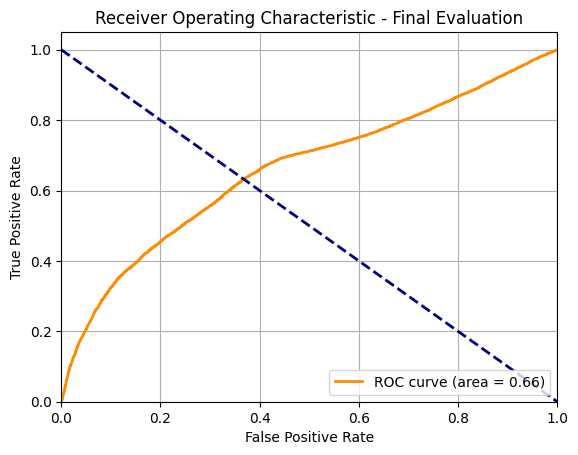

In [16]:
# Plot final ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Remove the original diagonal line and add the new line from (0, 1) to (1, 0)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Final Evaluation')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()